# XGB Model

Test date range: 2017,4,23 ~ 2017,5,31 (39 days).

We need 39 predictions for each date, for 821 stores each time. But, not enough data to fit 39 seperate models, even though the variables behave slightly differently on each day - so we trade off by fitting the first 4 days as a separate model, then further models in 2-week chunks.

Golden week factors should be calculated manually then appllied to the data post-prediction.

### To do  
* extend ewma into the future.
* Golden week.
* tune date length again?
* xgb linear mode

## Libraries, global variables

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime
from datetime import timedelta

# Graphics stuff
sns.set()
plt.rcParams["figure.figsize"] = [24,16]
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16) 

In [221]:
# Define the periods covered by each model, in days
# Python index notation
start_day = [0,4,18,32]
end_day = [4,18,32,39]


n_models = len(start_day)

# set datatypes for importing CSV files... other columns become float.
# Should have pickled instead of CSV!
datatypes = {"air_genre_name_Bar/Cocktail":np.uint8, "air_genre_name_Cafe/Sweets":np.uint8, "air_genre_name_Creative cuisine":np.uint8, "air_genre_name_Dining bar":np.uint8, "air_genre_name_Italian/French":np.uint8, "air_genre_name_Izakaya":np.uint8, "air_genre_name_Japanese food":np.uint8, "air_genre_name_Okonomiyaki/Monja/Teppanyaki":np.uint8, "air_genre_name_Other":np.uint8, "air_genre_name_Western food":np.uint8, "air_genre_name_Yakiniku/Korean food":np.uint8, "air_genre_name_genre_dropped":np.uint8, "kushi_Asahikawa-shi":np.uint8, "kushi_Bunkyō-ku":np.uint8, "kushi_Chiyoda-ku":np.uint8, "kushi_Chūō-ku":np.uint8, "kushi_Fukuoka-shi":np.uint8, "kushi_Fukuyama-shi":np.uint8, "kushi_Hamamatsu-shi":np.uint8, "kushi_Himeji-shi":np.uint8, "kushi_Hiroshima-shi":np.uint8, "kushi_Itabashi-ku":np.uint8, "kushi_Itoshima-shi":np.uint8, "kushi_Kakogawa-shi":np.uint8, "kushi_Kitakyūshū-shi":np.uint8, "kushi_Kurume-shi":np.uint8, "kushi_Kōbe-shi":np.uint8, "kushi_Kōtō-ku":np.uint8, "kushi_Meguro-ku":np.uint8, "kushi_Minato-ku":np.uint8, "kushi_Nakano-ku":np.uint8, "kushi_Niigata-shi":np.uint8, "kushi_Nishinomiya-shi":np.uint8, "kushi_Sapporo-shi":np.uint8, "kushi_Sendai-shi":np.uint8, "kushi_Setagaya-ku":np.uint8, "kushi_Shibuya-ku":np.uint8, "kushi_Shinagawa-ku":np.uint8, "kushi_Shinjuku-ku":np.uint8, "kushi_Suginami-ku":np.uint8, "kushi_Tachikawa-shi":np.uint8, "kushi_Taitō-ku":np.uint8, "kushi_Toshima-ku":np.uint8, "kushi_kushi_dropped":np.uint8, "kushi_Ōsaka-shi":np.uint8, "kushi_Ōta-ku":np.uint8, "todofuken_Fukuoka-ken":np.uint8, "todofuken_Hiroshima-ken":np.uint8, "todofuken_Hokkaidō":np.uint8, "todofuken_Hyōgo-ken":np.uint8, "todofuken_Miyagi-ken":np.uint8, "todofuken_Niigata-ken":np.uint8, "todofuken_Shizuoka-ken":np.uint8, "todofuken_Tōkyō-to":np.uint8, "todofuken_Ōsaka-fu":np.uint8}

## Pre-processing

Create variables needed when combining the date ranges, plus one or two things I didn't think to do in the original data-builder.

In [222]:
def pre_processing(dataframe, test=False, model_number=0):
    X = dataframe.copy()
    X = X.reset_index()
    
    ### Days ahead
    X["days_ahead"] = X["date"].map(lambda x: (x - prediction_date).days)
        

    ### Min / max for each store (same for genre*area is already in the file)
    stores = X["air_store_id"].unique()
    storemin, storemed, storemax = {}, {}, {}
    recent_visits = visits.reset_index().copy()
    recent_visits = recent_visits[ recent_visits["visit_date"] > prediction_date - timedelta(weeks=15) ]
    recent_visits = recent_visits.set_index(["air_store_id"])
    for store in stores:
        visitors = recent_visits.loc[store,"visitors"]
        storemin[store] = np.percentile(visitors, 16)
        storemed[store] = np.percentile(visitors, 50)
        storemax[store] = np.percentile(visitors,84)
    X["min"] = X["air_store_id"].map(lambda x: storemin[x])
    X["med"] = X["air_store_id"].map(lambda x: storemed[x])
    X["max"] = X["air_store_id"].map(lambda x: storemax[x])

#     ### Drop unnecessary variables
#     if model_number == 0:
#         X = X.drop([
#         #'air_genre_name_Bar/Cocktail', 'air_genre_name_Cafe/Sweets',  'air_genre_name_Izakaya','air_genre_name_Italian/French',
#             'air_genre_name_Creative cuisine', 'air_genre_name_Dining bar','air_genre_name_Japanese food','air_genre_name_Okonomiyaki/Monja/Teppanyaki', 'air_genre_name_Other','air_genre_name_Western food', 'air_genre_name_Yakiniku/Korean food','air_genre_name_genre_dropped',
#             #'atw_M-0', 'atw_M-1', 'atw_M-2','atw_M-3', 'atw_M-4', 'atw_M-5', 'atw_all', 
#            'kushi_Asahikawa-shi', 'kushi_Bunkyō-ku', 'kushi_Chiyoda-ku', 'kushi_Chūō-ku', 'kushi_Fukuoka-shi', 'kushi_Fukuyama-shi', 'kushi_Hamamatsu-shi', 'kushi_Himeji-shi', 'kushi_Hiroshima-shi', 'kushi_Itabashi-ku', 'kushi_Itoshima-shi', 'kushi_Kakogawa-shi', 'kushi_Kitakyūshū-shi', 'kushi_Kurume-shi', 'kushi_Kōbe-shi', 'kushi_Kōtō-ku', 'kushi_Meguro-ku', 'kushi_Minato-ku', 'kushi_Nakano-ku', 'kushi_Niigata-shi', 'kushi_Nishinomiya-shi', 'kushi_Sapporo-shi', 'kushi_Sendai-shi', 'kushi_Setagaya-ku', 'kushi_Shibuya-ku', 'kushi_Shinagawa-ku', 'kushi_Shinjuku-ku', 'kushi_Suginami-ku', 'kushi_Tachikawa-shi', 'kushi_Taitō-ku', 'kushi_Toshima-ku', 'kushi_kushi_dropped', 'kushi_monthly_effects', 'kushi_weekday_effects', 'kushi_Ōsaka-shi', 'kushi_Ōta-ku',
#            #'todofuken_Fukuoka-ken', 'todofuken_Hiroshima-ken','todofuken_Hokkaidō', 'todofuken_Hyōgo-ken', 'todofuken_Miyagi-ken','todofuken_Niigata-ken', 'todofuken_Shizuoka-ken', 'todofuken_Tōkyō-to','todofuken_Ōsaka-fu',
#            #'visits_M-0', 'visits_M-1', 'visits_M-2', 'visits_M-3', 'visits_M-4','visits_M-5', 'visits_W-0', 'visits_W-1', 'visits_W-2', 'visits_W-3',
#         ], axis=1)
    
    
    # Holt's EWMA TS (exponentially weighted moving average time series)
    levels, trends = {}, {}
    a = 0.1
    b = 0.1
    for store in stores:
        all_visitors = visits.reset_index().set_index(["air_store_id"]).loc[store,"visitors"].values
        # calc ewma
        level = all_visitors.mean()
        trend = 0
        for visit in all_visitors:
            old_trend = trend
            old_level = level
            level = a*visit + (1-a)*(old_level + old_trend)
            trend = b*(level - old_level) + (1-b)*old_trend
        levels[store] = level
        trends[store] = trend
        
    # save to DF, but only for first data period
#     def get_ewma(x):
#         store = x["air_store_id"]
#         days_ahead = x["days_ahead"]
#         level = levels[store]
#         if days_ahead < end_day[0]:
#             trend = trends[store]
#             return level + (days_ahead+1)*trend
#         else:
#             return levels[store]
#     X["ewma"] = X.apply(get_ewma, axis=1)
    # actually it works better without the future prediction...
    X["ewma"] = X["air_store_id"].map(lambda x: levels[x])
    
    # latlon - no benefit
#     store_info = pd.read_csv("../input/air_store_info.csv").set_index("air_store_id")
#     X["latlon"] = X["air_store_id"].map(lambda x: store_info.loc[x, "latitude"] + store_info.loc[x, "longitude"])

    ### Day of the week
#     X["dow"] = X["date"].dt.dayofweek 
# or    
#     X["weekday"] = X["date"].map(lambda x: x.strftime("%a"))
#     X = pd.concat([X, pd.get_dummies(X["weekday"])], axis=1)
#     X.drop(["weekday"], axis=1, inplace=True)



    # Add in the predictions from the surprise me kernel
    if test:
        surprise = pd.read_csv("../input/surpriseme_submission_test.csv")
    else:
        surprise = pd.read_csv("../input/surpriseme_submission_eval.csv")
    surprise['date'] = surprise['id'].map(lambda x: str(x).split('_')[2])
    surprise['air_store_id'] = surprise['id'].map(lambda x: '_'.join(x.split('_')[:2]))
    surprise['date'] = pd.to_datetime(surprise['date'])
    surprise = surprise.drop(["id"], axis=1)
    
    X = pd.merge(X, surprise, how='left', on=['air_store_id','date']) 
    X = X.rename(columns={'visitors':'surprise'})
    
    
    # Predictions from my chainer model
    if test:
        chainer = pd.read_csv("../chainer/predictions/average_test.csv")
    else:
        chainer = pd.read_csv("../chainer/predictions/average_eval.csv")
    chainer['date'] = pd.to_datetime(chainer['date'])
    X = pd.merge(X, chainer, how='left', on=['air_store_id','date']) 
    X = X.rename(columns={'visitors':'chainer'})
    

    X = X.set_index(["air_store_id","date"])
    
    return X

## Prepare X and y Train Data

In [223]:
# Define date range for TRAIN data
# (note pandas indexing different to standard python)
prediction_date = datetime(2017,4,23) - timedelta(days=39)
prediction_length = timedelta(days = 38)
date_range = pd.date_range(prediction_date, prediction_date + prediction_length)

# Read in the tabulated files
frames = []
for date in date_range:
    frames.append( pd.read_csv("tabular_data/" + date.strftime("%Y_%m_%d") + ".csv", dtype=datatypes) )

# Prep empty X and y objects
# This is a weird way for X but otherwise the columns have the wrong dtypes.
X_empty = frames[0].copy()
X_empty.drop(X_empty.index, inplace=True)
X_train_all = []
y_train_all = []

print("Building models.")
for m in range(n_models):

    X_train = X_empty.copy()
    y_train = []

    # Scan and concat certain date range into X and y
    for (date, i) in zip(date_range[start_day[m]:end_day[m]], range(start_day[m],end_day[m])):

        X_ = frames[i]
        X_["date"] = date.date()
        X_train = pd.concat([X_train, X_], axis=0)

        # Also prepare the targets
        y_ = []

        # Use visits database
        visits = pd.read_csv("../input/air_visit_data.csv", parse_dates=["visit_date"], index_col=["visit_date", "air_store_id"])
        visits = visits.sort_index()

        # Get target values
        # Loop over stores index to make sure the order is correct
        for store in X_["air_store_id"]:
            if (date, store) in visits.index:
                y_.append(visits.loc[(date, store), "visitors"])
            else:
                y_.append(0)

        # concat together
        y_train.extend(y_)

    X_train.set_index(["air_store_id","date"], inplace=True)
    
    X_train = pre_processing(X_train, model_number=m)
    
    y_train = pd.Series(index = X_train.index, data = y_train)

    print("For model",m,"X has shape", X_train.shape, "and y has shape", y_train.shape)
    X_train_all.append(X_train)
    y_train_all.append(y_train)

Building models.
For model 0 X has shape (3284, 93) and y has shape (3284,)
For model 1 X has shape (11494, 93) and y has shape (11494,)
For model 2 X has shape (11494, 93) and y has shape (11494,)
For model 3 X has shape (5747, 93) and y has shape (5747,)


## Define and Fit Model

In [224]:
### Define metrics
from sklearn.metrics import make_scorer, mean_squared_log_error
from math import sqrt,log

# Custom function to return RMSLE
# where items with true=0 will not be scored
def get_score(true, pred):
    a, b = [], []
    for i in range(len(true)):
        if true[i] != 0:
            a.append(true[i])
            # Guard against negative predictions
            if pred[i] > 0:
                b.append(pred[i])
            else:
                b.append(0)
    return sqrt(mean_squared_log_error(a, b))
    
# sklearn metric
def metric_skl(est, X, y):
    y_pred = est.predict(X)
    return get_score(y, y_pred)

# XGBoost metric
# XGB sends "true" as custom datatype, and in the reverse order...
def metric_xgb(pred, true):
    true = true.get_label()
    return ("RMSLE", get_score(true, pred))

### Define model
from xgboost import XGBRegressor
xgb = XGBRegressor()

# set params
xgb.max_depth = 4
xgb.colsample_by_tree = 0.7
xgb.n_estimators = 65
xgb.min_child_weight = 0.8
xgb.learning_rate=0.05

# Custom tuning for each model
n_est = [65, 67, 81, 63]
max_dep = [4,4,5,5]

In [225]:
# Quick Test Fit on split data, to get n_est
from sklearn.model_selection import train_test_split

def test_fit(X,y):
    old_nestimators = xgb.n_estimators
    xgb.n_estimators = 150
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    xgb.fit(X_train, y_train, eval_metric=metric_xgb, verbose = True, eval_set=[(X_test,y_test)], early_stopping_rounds=5)
    y_predicted = xgb.predict(X_test)
    print("Test RMSLE:", "{0:.4}".format(get_score(y_test.values, y_predicted)),
          "at best iteration:", xgb.best_iteration)
    xgb.n_estimators = old_nestimators #xgb.best_iteration
    return (y_predicted, y_test)
    
# test_fit(X_train_all[2], y_train_all[2])
y_predicted, y_true = [], []

#Fit for each model
for m in range(n_models):
    
    X = X_train_all[m]
    y = y_train_all[m]
    
    xgb.n_estimators = n_est[m]
    xgb.max_depth = max_dep[m]
    
    # Get predictions and truth for plotting
    from sklearn.model_selection import cross_val_predict
    y_predicted.extend(cross_val_predict( xgb, X.values, y.values, cv=4).tolist() )
    y_true.extend(y.values.tolist())

    # Proper cross-val score
    from sklearn.model_selection import cross_val_score
    cvscore = cross_val_score( xgb, X.values, y.values, scoring=metric_skl, cv=4)
    print("Cross-train RMSLE for model "+str(m)+":",'{0:.4}'.format(cvscore.mean()))

    # Fit model on all data
    xgb.fit(X, y, eval_metric=metric_xgb)

    # Save model
    import pickle
    pickle.dump(xgb, open("xgb_models/xgb"+str(m), 'wb'))
    
print("Overall score:", get_score(y_true, y_predicted))

Cross-train RMSLE for model 0: 0.4518
Cross-train RMSLE for model 1: 0.5006
Cross-train RMSLE for model 2: 0.4888
Cross-train RMSLE for model 3: 0.4659
Overall score: 0.4839490264282271


### Previous best RMSLE
Cross-train RMSLE for model 0: 0.452 (18)
Cross-train RMSLE for model 1: 0.5006 (02)
Cross-train RMSLE for model 2: 0.4888
Cross-train RMSLE for model 3: 0.4659
Overall score: 0.483977636671546

## Run the Models on Test Data

In [226]:
# Date range for TEST data
prediction_date = datetime(2017,4,23)
prediction_length = timedelta(days = 38)
date_range = pd.date_range(prediction_date, prediction_date + prediction_length)

# load predictors
frames = []
for date in date_range:
    frames.append( pd.read_csv("tabular_data/test/" + date.strftime("%Y_%m_%d") + ".csv", dtype=datatypes) )
    
# Prepare empty predictors
y_pred = pd.Series()

# For each model time period
for m in range(n_models):
    
    X = X_empty.copy()
    
    # Concat all values in this time period
    for (date, i) in zip(date_range[start_day[m]:end_day[m]], range(start_day[m],end_day[m])):
        X_ = frames[i]
        X_["date"] = date.date()
        X = pd.concat([X, X_], axis=0)

    X.set_index(["air_store_id","date"], inplace=True)
    X = pre_processing(X, test=True, model_number=m)

    # Remove GW marker
    if "gw_effect" in X.columns:
        X = X.drop(["gw_effect"], axis=1)
    
    print("For model " + str(m) + ", X has shape",X.shape)
    
    # Predict and save
    xgb = pickle.load(open("xgb_models/xgb"+str(m), 'rb'))
    preds = xgb.predict(X)

    y_pred_ = pd.Series(index=X.index, data=xgb.predict(X))
    y_pred = pd.concat([y_pred_,y_pred], axis=0)

For model 0, X has shape (3284, 93)
For model 1, X has shape (11494, 93)
For model 2, X has shape (11494, 93)
For model 3, X has shape (5747, 93)


## Post-processing and output

In [230]:
# copy to dataframe
y_pred.name = "visitors"
preds = pd.DataFrame(y_pred)

# Golden week - calculated from 2016 data, plus guesstimation within calculated 1-sigma errors

# Re-append genre and area name to the preds temporarily
stores = pd.read_csv("../input/air_store_info.csv").drop(["latitude","longitude"], axis=1)
stores["todofuken"] = stores["air_area_name"].map(lambda x: str.split(x)[0])
stores = stores.drop(["air_area_name"], axis=1)
preds = pd.merge(preds.reset_index(),stores, how="left", on=["air_store_id"])

### merge GW factors
# area-based factors
area_factors = pd.read_csv("golden_week/area_factors.csv", parse_dates=["date"])
preds = pd.merge(preds,area_factors, how="left", on=["date","todofuken"])
# specific genre & area factors
specific_factors = pd.read_csv("golden_week/specific_factors.csv", parse_dates=["date"])
preds = pd.merge(preds,specific_factors, how="left", on=["date","air_genre_name","todofuken"])
# Week after factor
weekafter_factors = pd.read_csv("golden_week/weekafter_factors.csv", parse_dates=["date"])
preds = pd.merge(preds,weekafter_factors, how="left", on=["date","air_genre_name"])

# apply factors
preds["factor"] = preds.apply(lambda x: x["specific_factor"] if x["specific_factor"] > 0 else x["factor"], axis=1)
preds["factor"] = preds.apply(lambda x: x["weekafter_factor"] if x["weekafter_factor"] > 0 else x["factor"], axis=1)
preds["factor"] = preds.apply(lambda x: x["factor"] if x["factor"] > 0 else 1., axis=1)
preds = preds.drop(["air_genre_name","todofuken","specific_factor","weekafter_factor"], axis=1)

# Second submission only (reduce GW estimate factor strength):
#preds["factor"] = preds["factor"].map(lambda x: x**0.73)
    
preds["visitors"] = preds["visitors"] * preds["factor"]
preds = preds.drop(["factor"], axis=1)

In [231]:
# Final processing

# Remove negative values and round up to 1
# as all 0-visit days are not scored!
preds["visitors"] = preds["visitors"].map(lambda x: 1 if x<1 else x)

# Remove high values?
#preds["visitors"] = preds["visitors"].map(lambda x: 200 if x>200 else x)

# Round? rounding seems to decrease score...
#from math import floor, ceil
#preds["visitors"] = preds["visitors"].map(lambda x: ceil(x))

In [232]:
# Make the submission file
preds["id"] = preds.apply(lambda x: x["air_store_id"] + "_" + str(x["date"].date()), axis=1)
preds = preds.drop(["air_store_id", "date"], axis=1).set_index(["id"]).sort_index()
preds.to_csv("submission.csv")

In [219]:
preds.head()

,visitors
id,
air_00a91d42b08b08d9_2017-04-23,1.000000
air_00a91d42b08b08d9_2017-04-24,22.979322
air_00a91d42b08b08d9_2017-04-25,30.588816
air_00a91d42b08b08d9_2017-04-26,29.575729
air_00a91d42b08b08d9_2017-04-27,35.631531


# Other Stuff
---
## Linear model for score comparison

In [156]:
# Baseline linear regression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train2 = X_train.replace(np.nan, 0)
X_test2 = X_test.replace(np.nan, 0)

from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train2,y_train)
y_pred2 = reg.predict(X_test2)
for i in range(len(y_pred2)):
    if y_pred2[i]<0:
        y_pred2[i]=0
y_pred2
print("RMSLE:", get_score(y_test, y_pred2))

RMSLE: 0.6199964509056897


## Plotting

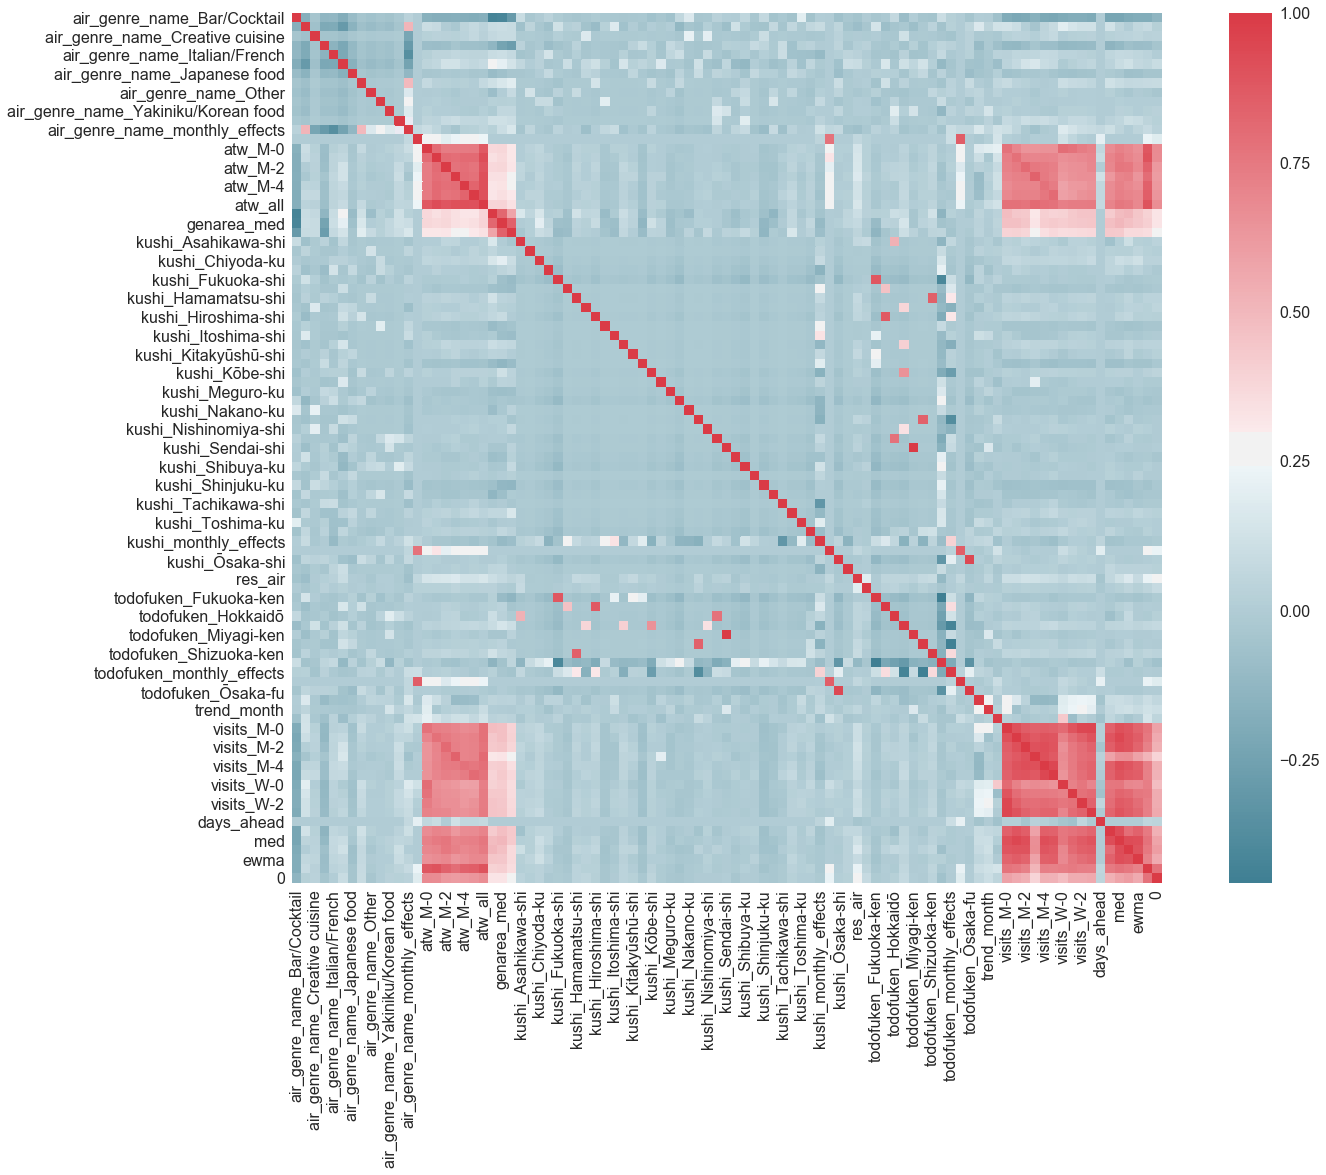

In [157]:
# plot correlation matrix
Xy = pd.concat([X_train_all[1], y_train_all[1]], axis=1)
sns.heatmap(Xy.corr(),  cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)
plt.show()

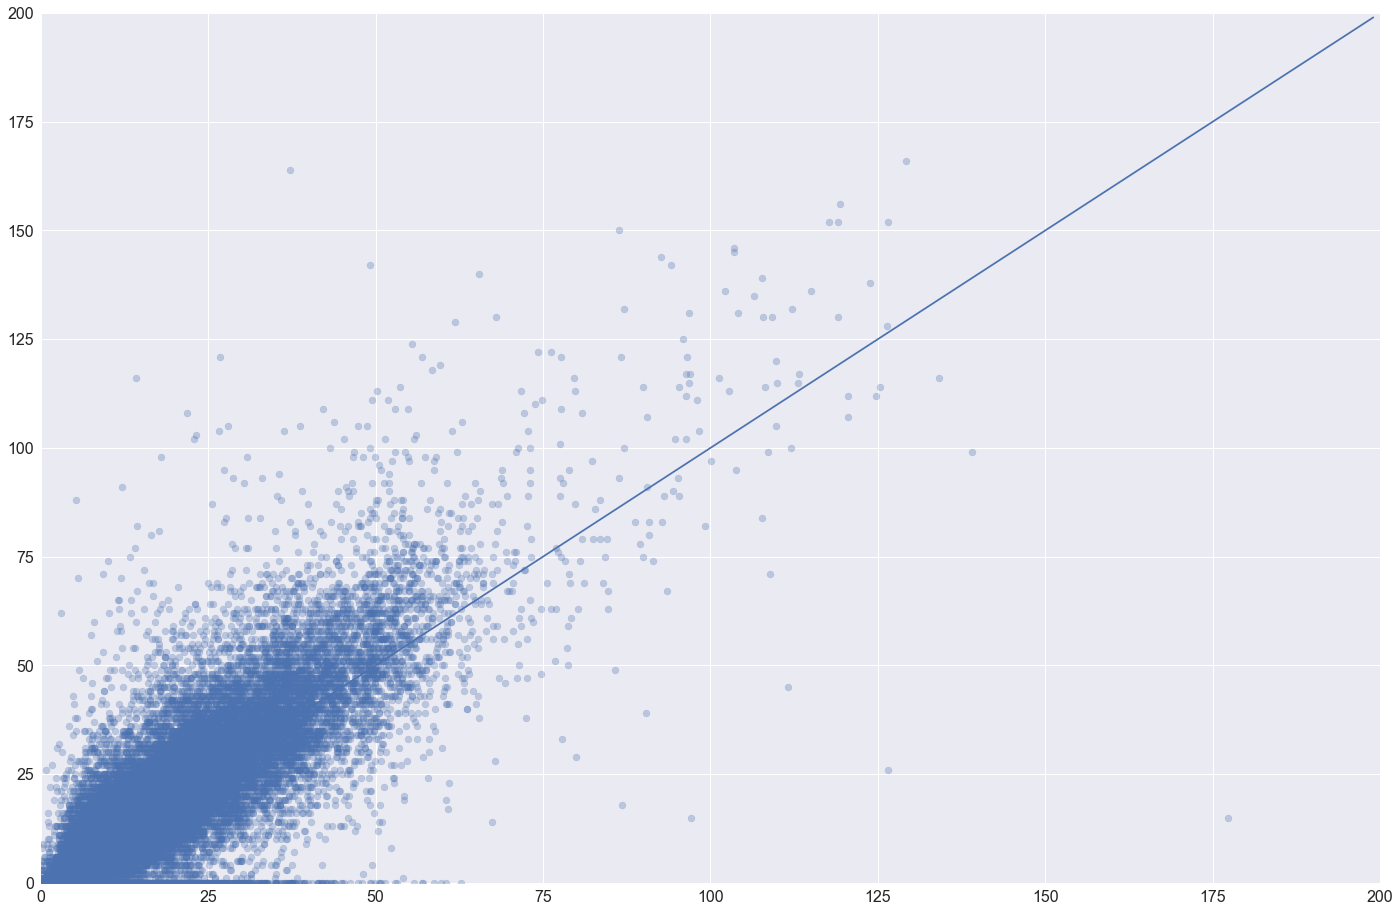

In [200]:
#plt.scatter(np.log(y_predicted), np.log(y_true))
plt.scatter(y_predicted, y_true, alpha=0.3)
#print(get_score(y_predicted, y_test))
plt.plot(range(200))
plt.xlim(0,200)
plt.ylim(0,200)
plt.show()

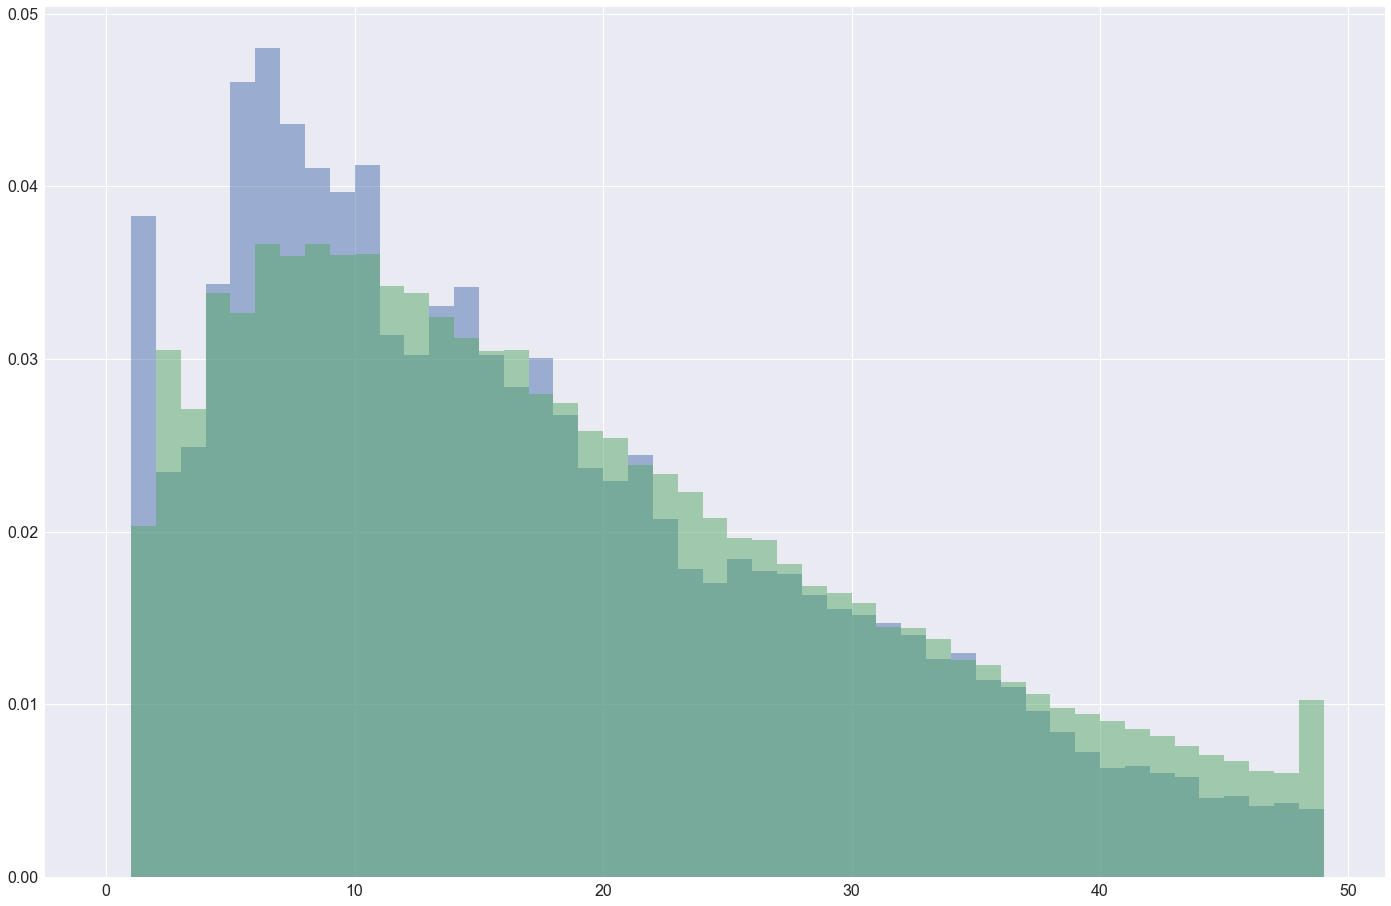

In [34]:
#bins = np.divide(range(250), 10)
#sns.distplot(preds, bins=bins, kde=False)

bins = list(range(50))
plt.hist(preds.values, bins=bins, alpha=0.5, normed=True)
plt.hist(visits.values, bins=bins, alpha=0.5, normed=True)
plt.show()

In [79]:
fscore = xgb.booster().get_fscore()
import xgboost
xgboost.plot_importance(xgb.booster())
plt.show()

XGBoostError: need to call fit beforehand

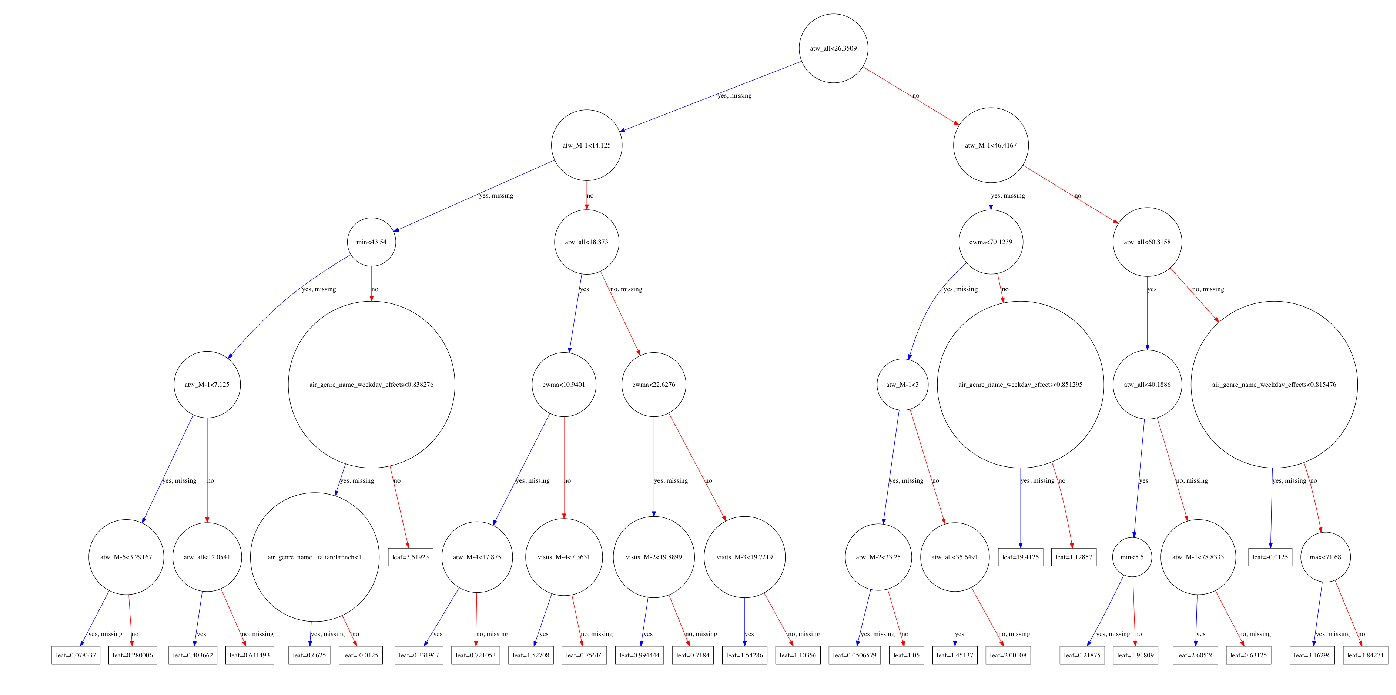

In [35]:
from xgboost import plot_tree
plot_tree(xgb)
plt.show()

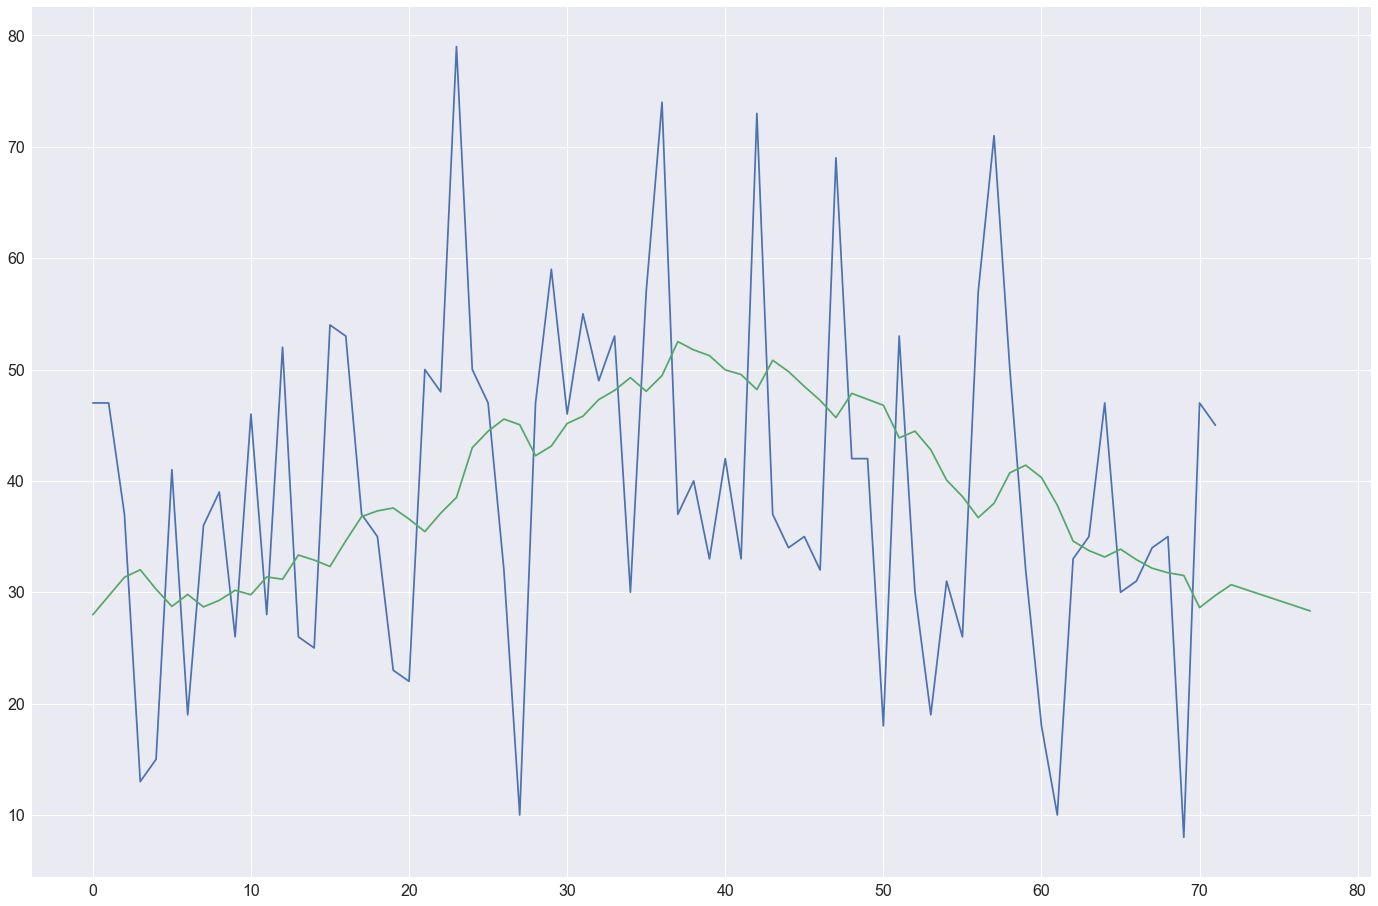

In [61]:
all_visitors = visits.reset_index().set_index(["air_store_id"]).loc["air_04341b588bde96cd","visitors"].values

# Simple EWMA
a = 0.1
EWMA = all_visitors.mean()
plot_ewma = [EWMA]

for visit in all_visitors:
    EWMA = (a*visit) + ((1-a)*EWMA)
    plot_ewma.append(EWMA)

# Holt's linear-extrapolation EWMA
level = all_visitors.mean()
trend = 0
plot_level = [level]
plot_trend = [trend]
a = 0.1
b = 0.1

for visit in all_visitors:
    old_trend = trend
    old_level = level
    level = a*visit + (1-a)*(old_level + old_trend)
    trend = b*(level - old_level) + (1-b)*old_trend
    plot_level.append(level)
    plot_trend.append(trend)
    
# Extrapolate into the future
for i in range(5):
    plot_level.append(plot_level[-1] + plot_trend[-1])
    
        
plt.plot(all_visitors[400:])
plt.plot(plot_level[400:])
plt.show()

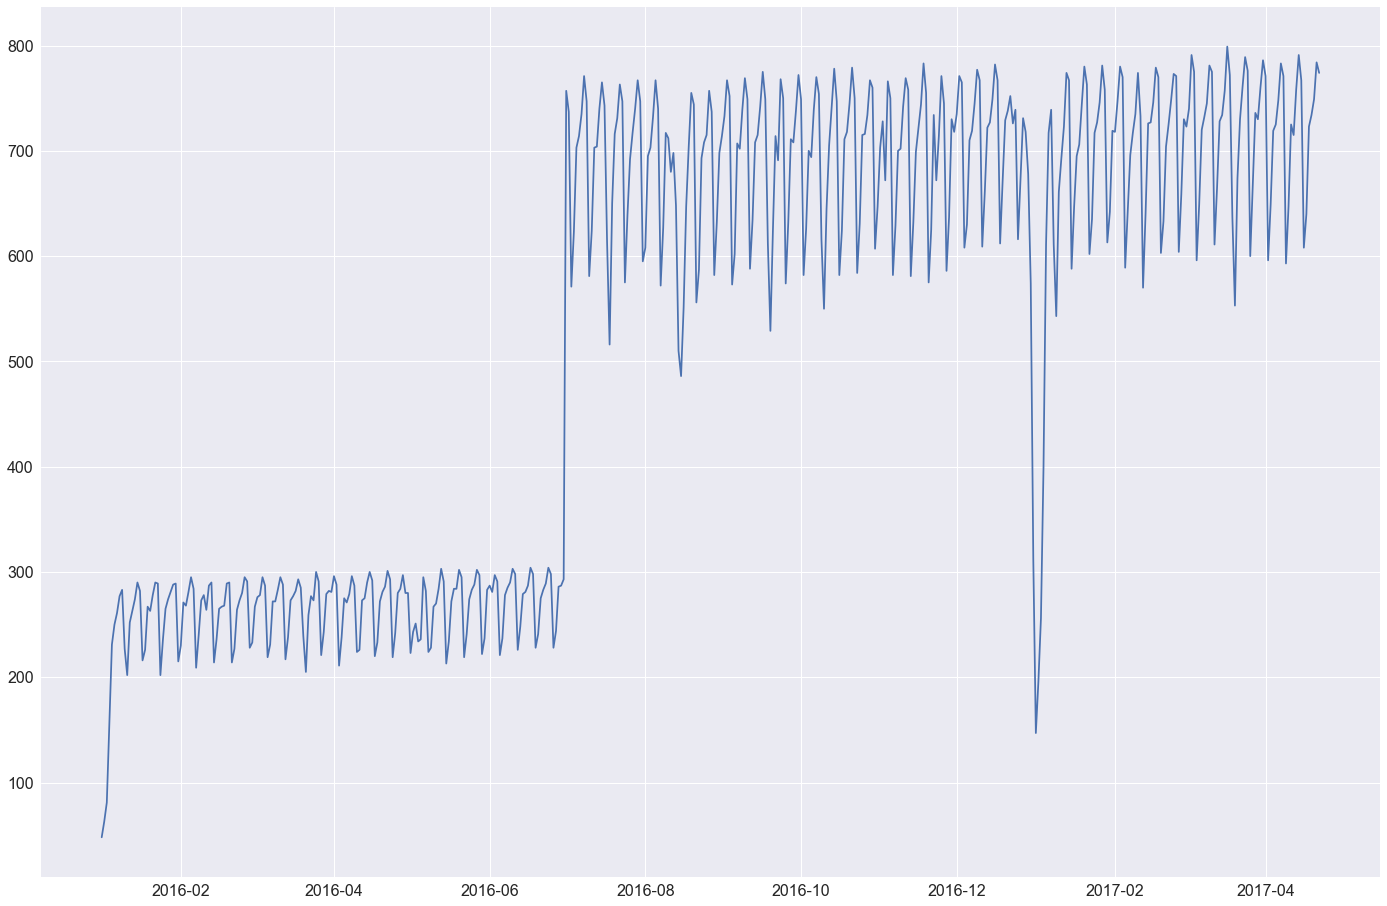

In [69]:
dates = visits.reset_index()
dates = dates.drop(["visitors"], axis=1)
uniques = []
i = 0
for date in dates["visit_date"].unique():
    i += 1
    uniques.append(len(dates[ dates["visit_date"] ==date ]["air_store_id"].unique()))
#    print(date, i, uniques[-1])
    
plt.plot(dates["visit_date"].unique(), uniques)
plt.show()

